# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

/Users/pmw/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Only need to run this cell once
path = '/Users/pmw/Documents/Harvard/CS109/data/'#'C:/Users/pmwash/Downloads/'
df_train = pd.read_csv(path + 'Bikeshare_train.csv', header=0)
df_test = pd.read_csv(path + 'Bikeshare_test.csv', header=0)

def pre_process_data(df):
    '''
    Provides meaning to either test or train BikeShare data by
      - Providing categories with names
      - Deriving dummy variables
      - Ordered Categorical variables for plotting
    
    Inputs
    --------------------------------------
    df: raw bikeshare data as a pd.DataFrame object
    
    Outputs
    --------------------------------------
    df: modified ready for plotting
    '''
    del df['Unnamed: 0']
    
    # map values to codes
    dow = {1:'monday', 2:'tuesday', 3:'wednesday', 4:'thursday', 5:'friday', 6:'saturday', 0:'sunday'}
    season = {1:'winter', 2:'spring', 3:'summer', 4:'fall'}
    weather = {1:'clear', 2:'cloudy', 3:'rain/snow', 4:'severe'} 
    month = {1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul', 8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}
    df.season = df.season.map(season)
    df.day_of_week = df.day_of_week.map(dow)
    df.weather = df.weather.map(weather)
    df.month = df.month.map(month)
    
    # derive dummy variables
    df = pd.concat([df, pd.get_dummies(df.day_of_week, drop_first=True)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.season, drop_first=True)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.weather, drop_first=True)], axis=1)
    df = pd.concat([df, pd.get_dummies(df.month, drop_first=True)], axis=1)
    
    # place ordered cateogricals for plotting
    df.day_of_week = pd.Categorical(df.day_of_week, categories=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'], ordered=True)
    df.season = pd.Categorical(df.season, categories=['winter', 'spring', 'summer', 'fall'], ordered=True)
    df.weather = pd.Categorical(df.weather, categories=['clear', 'cloudy', 'rain/snow', 'severe'], ordered=True)
    df.month = pd.Categorical(df.month, categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], ordered=True)
    
    return df
    
df_train = pre_process_data(df_train)
df_test = pre_process_data(df_test)

from sklearn.preprocessing import StandardScaler

# id scale columns and rename new columns
cols_to_scale = ['temp', 'atemp', 'humidity', 'windspeed']
scale_cols = ['scaled_'+str(col) for col in cols_to_scale]

for col, new_col in zip(cols_to_scale, scale_cols):
    # fitting scaler with training data
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(df_train[col].values.reshape(-1, 1))
    
    # centering both train and test data using the training mean and std dev
    df_train[new_col] = scaler.transform(df_train[col].values.reshape(-1, 1))
    df_test[new_col] = scaler.transform(df_test[col].values.reshape(-1, 1))

# drop raw categorical and continuous columns in preparation for ML algorithms
drop_cols = ['season', 'month', 'weather', 'day_of_week', 'temp', 'atemp', 'humidity', 'windspeed']
df_train = df_train.drop(drop_cols, axis=1)
df_test = df_test.drop(drop_cols, axis=1)

# write to csv
df_train.to_csv(path + 'Bikeshare_Train_Procsessed.csv', index=False)
df_test.to_csv(path + 'Bikeshare_Test_Procsessed.csv', index=False)

In [3]:
# read in preprocessed data
df_train = pd.read_csv(path + 'Bikeshare_Train_Procsessed.csv', header=0)
df_test = pd.read_csv(path + 'Bikeshare_Test_Procsessed.csv', header=0)

df_train.head()

,holiday,workingday,count,monday,saturday,sunday,thursday,tuesday,wednesday,spring,...,jun,mar,may,nov,oct,sep,scaled_temp,scaled_atemp,scaled_humidity,scaled_windspeed
0,0.0,1.0,6073.0,0,0,0,0,1,0,1,...,0,0,1,0,0,0,0.624743,0.651090,0.922058,-0.930164
1,0.0,1.0,6606.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,-0.180583,-0.054841,0.697907,-0.213825
2,0.0,1.0,7363.0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0.803704,0.852785,-0.449062,0.805143
3,0.0,0.0,2431.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,-1.522794,-1.567551,-0.332616,-0.269507
4,0.0,1.0,1996.0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0.535262,0.348548,1.978781,-1.200843


# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

In [4]:
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 999)

# from pre-processed data select x_train, y_train, x_test, and y_test
x_train, y_train = df_train[[col for col in df_train.columns if col != 'count']], df_train['count']
x_test, y_test = df_test[[col for col in df_test.columns if col != 'count']], df_test['count']

# split x_train and y_train into training & validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=7)

print('''
Shape x_train:    %s
Shape y_train:    %s

Shape x_val:      %s
Shape y_val:      %s

Shape x_test:     %s
Shape y_test:     %s
''' %(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape))


Shape x_train:    (221, 28)
Shape y_train:    (221,)

Shape x_val:      (110, 28)
Shape y_val:      (110,)

Shape x_test:     (400, 28)
Shape y_test:     (400,)



Best lambda for Ridge Regression:
 [ 10.] 

lambda                  10.0
r_squared           0.493462
aug               -52.696096
cloudy             79.841181
dec              -104.803890
feb              -197.629296
holiday           -99.744644
jan              -325.991546
jul              -403.788301
jun              -556.187965
mar                13.160063
may                33.151719
monday           -187.787035
nov               225.473051
oct               425.671911
rain/snow        -668.406445
saturday          200.722050
scaled_atemp      783.104085
scaled_humidity  -539.646679
scaled_temp       355.186824
scaled_windspeed -241.925575
sep               597.323691
spring           -157.105900
summer           -380.256857
sunday           -234.772735
thursday         -224.859859
tuesday          -177.683691
wednesday          -5.455067
winter           -810.104544
workingday        133.795329


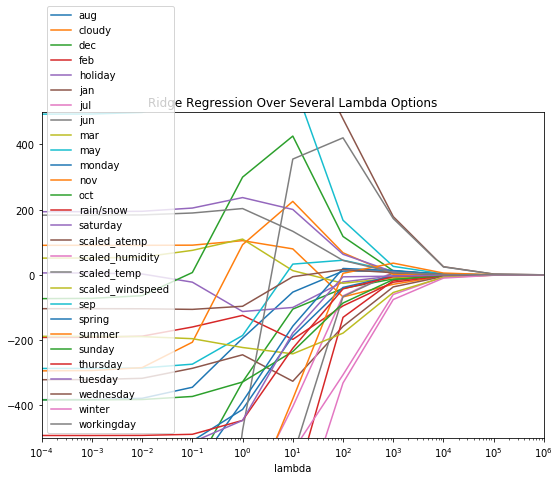

In [5]:
# Ridge regression

# identify lambda options on which to train 
lambdas = [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e-0, 10e1, 10e2, 10e3, 10e4, 10e5]

def ridge_regression(x_train, y_train, x_val, y_val, alpha):
    '''
    Inputs:
    --------------------------
    x_train: pre-normalized X variables
    y_train: y-label
    x_val: pre-split (from training df) X for validation
    y_val: pre-split (from training df) Y for validation
    alpha: lambda value for Ridge() object
    
    Outputs:
    --------------------------
    r2_val: validation R-squared score
    ridge_reg: fitted ridge regression model
    '''
    ridge_reg = Ridge(alpha=alpha, fit_intercept=True, normalize=False)
    ridge_reg.fit(x_train, y_train)
    y_hat = ridge_reg.predict(x_val)
    r2_val = r2_score(y_val, y_hat)
    
    return r2_val, ridge_reg

# compile data for each lambda
coef_r2_ridge = []
for i, alpha in enumerate(lambdas):
    r2, ridge_reg_l = ridge_regression(x_train, y_train, x_val, y_val, alpha)
    data = {'lambda':alpha, 'r_squared':r2}
    data.update({col:coef for (col, coef) in zip(x_train.columns, ridge_reg_l.coef_)})
    coef_r2_ridge.append(data)
    
df_ridge = pd.DataFrame(coef_r2_ridge)
df_ridge.set_index(['lambda', 'r_squared'], inplace=True, drop=True)

# show max r-squared on validation and save it for later
ridge_best_lambda = df_ridge[df_ridge.index.get_level_values(1) == \
                             df_ridge.index.get_level_values(1).max()].index.get_level_values(0).values
print('Best lambda for Ridge Regression:\n %s \n' %ridge_best_lambda)
print(df_ridge[df_ridge.index.get_level_values(1) == df_ridge.index.get_level_values(1).max()].T)

df_ridge.plot(x=df_ridge.index.get_level_values(0), figsize=(9, 6), logx=True, ylim=(-500,500))
plt.title('Ridge Regression Over Several Lambda Options')

/Users/pmw/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best lambda for Lasso Regression:
 [ 10.] 

lambda                   10.0
r_squared            0.457576
aug                 -0.000000
cloudy               0.000000
dec                 -0.000000
feb                 -0.000000
holiday             -0.000000
jan                -22.477224
jul               -451.586030
jun               -826.348393
mar                 75.744774
may                 -0.000000
monday            -261.390879
nov                136.204111
oct                374.605055
rain/snow        -1460.574157
saturday            97.373445
scaled_atemp      1189.883080
scaled_humidity   -510.099727
scaled_temp         -0.000000
scaled_windspeed  -213.057842
sep                777.477784
spring            -226.394797
summer            -622.042644
sunday            -353.873811
thursday          -255.508208
tuesday           -196.547019
wednesday            0.000000
winter           -1240.459002
workingday           3.415855


,lasso_scaled_temp,lasso_scaled_atemp,ridge_scaled_temp,ridge_scaled_atemp
lambda,,,,
0.0001,-2010.291302,3232.187815,-2018.157893,3239.557204
0.0010,-2010.034698,3231.961763,-2014.651663,3236.211290
0.0100,-2007.728380,3229.920167,-1980.111169,3203.240705
0.1000,-1985.585098,3210.373181,-1680.006296,2915.989701
1.0000,-1744.079514,2985.139237,-475.993471,1737.602268
10.0000,-0.000000,1189.883080,355.186824,783.104085
100.0000,0.000000,979.901391,420.314782,478.296914
1000.0000,0.000000,200.506873,172.809052,178.805086
10000.0000,0.000000,0.000000,24.565091,25.151759


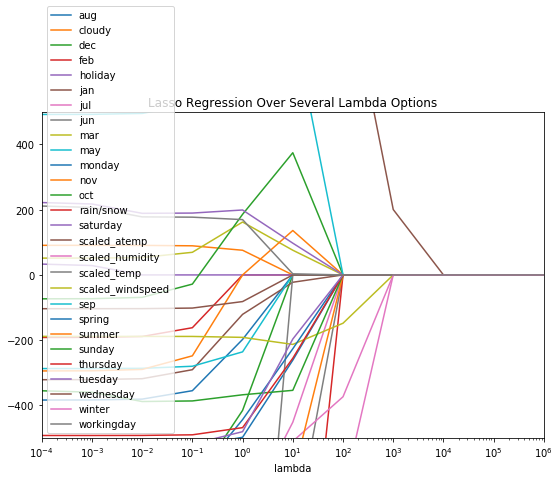

In [6]:
# LASSO regression
def lasso_regression(x_train, y_train, x_val, y_val, alpha):
    '''
    Inputs:
    --------------------------
    x_train: pre-normalized X variables
    y_train: y-label
    x_val: pre-split (from training df) X for validation
    y_val: pre-split (form training df) X for validation
    alpha: lambda value for Lasso() object
    
    Outputs:
    --------------------------
    r2_val: validation R-squared score
    lasso_reg: fitted lasso regression
    '''
    lasso_reg = Lasso(alpha=alpha, fit_intercept=True, normalize=False)
    lasso_reg.fit(x_train, y_train)
    y_hat = lasso_reg.predict(x_val)
    r2_val = r2_score(y_val, y_hat)
    
    return r2_val, lasso_reg

# compile data for each lambda
coef_r2_lasso = []
for i, alpha in enumerate(lambdas):
    r2, lasso_reg_l = lasso_regression(x_train, y_train, x_val, y_val, alpha)
    data = {'lambda':alpha, 'r_squared':r2}
    data.update({col:coef for (col, coef) in zip(x_train.columns, lasso_reg_l.coef_)})
    coef_r2_lasso.append(data)
    
df_lasso = pd.DataFrame(coef_r2_lasso)
df_lasso.set_index(['lambda', 'r_squared'], inplace=True, drop=True)

# identify and save best lambda for lasso
lasso_best_lambda = df_lasso[df_lasso.index.get_level_values(1) == \
                             df_lasso.index.get_level_values(1).max()].index.get_level_values(0).values
print('Best lambda for Lasso Regression:\n %s \n' %lasso_best_lambda)

print(df_lasso[df_lasso.index.get_level_values(1) == df_lasso.index.get_level_values(1).max()].T)

df_lasso.plot(x=df_lasso.index.get_level_values(0), figsize=(9, 6), logx=True, ylim=(-500,500))
plt.title('Lasso Regression Over Several Lambda Options')

temp_lasso = df_lasso[['scaled_temp','scaled_atemp']]
temp_lasso.columns = ['lasso_' + col for col in temp_lasso.columns]
temp_lasso.index = temp_lasso.index.droplevel(1)

temp_ridge = df_ridge[['scaled_temp','scaled_atemp']]
temp_ridge.columns = ['ridge_' + col for col in temp_ridge.columns]
temp_ridge.index = temp_ridge.index.droplevel(1)

temp_lasso.join(temp_ridge)

### Comparing Ridge & Lasso to Simple Linear Regression

The multiple regression model performed in Part (b) is a good benchmark for comparing the results of the Ridge & Lasso regularization techniques because all three were regressed on all of the predictors/features present in the dataset.

The original linear model returned coefficients that were larger in magnitude when compared to both Ridge and Lasso. When comparing the coefficients between Ridge and Lasso, it appears that Ridge's coefficients are larger in magnitude when compared with Lasso for many of the estimated coefficients. The reason for this is the fact that the 'optimal' lambda that was iteratively chosen for Lasso is 1.0, while the 'optimal' lambda for Ridge is 0.01. This means that Ridge's tiny lambda was enough in some cases to overcome the squared L2 loss function of Ridge regression. However, if the optimal lambda was equal, then it is likely that Ridge regression would yield smaller coefficients than Lasso for those values that Lasso did not push to zero. Otherwise, Lasso would return many zeros at high enough lambda values.

It is interesting to note that, under the best lambda, only one of the Lasso coefficients was forced to zero: `nov`. As can be shown on the plot of the coefficient magnitudes over various lambda values for Lasso regression, most of the coefficients go to zero at $\lambda = 100$, and only one remains at $\lambda = 1000$. This is due to the L1 loss function's brute force of bringing coefficients to zero, whereas L2 will preserve at least some value for each coefficient (rarely pushing them to zero).

Under Ridge regression none of the coefficients were forced to zero under the best lambda value of 0.01.

Both Ridge and Lasso regression treated `scaled_temp` and `scaled_atemp` similarly, with the one caveat that Lasso exhibited higher magnitude values for only one of these values: `scaled_atemp`. The coefficient for `scaled_temp` was ~906 under Lasso and ~922 under Ridge, while the coefficient for `scaled_atemp` was ~326 under Lasso and 313 under Ridge. Lasso is shown to push both of these variables to zero above values of $\lambda = 1000$ for `scaled_temp` and $\lambda = 10000$ for `scaled_atemp`, whereas Ridge is shown to include the signal 

## Part (f): Regularization/Penalization Methods (cont.)

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [7]:
def sample(x, y, k):
    '''
    A function to select a random sample of size k from the training set
    
    Inputs
    --------------------------------------
    x: (n x d array of predictors in training data)
    y: (n x 1 array of response variable vals in training data)
    k: (size of sample) 
    
    Outputs
    --------------------------------------
    (x_subset, y_subset): chosen sample of predictors and responses
    '''
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)


# define sample sizes 100 to 400 in increments of 50
sample_sizes = np.arange(100, 401, 50).tolist()

# re-define x_train to return to normal size (no validation set)
x_train, y_train = df_train[[col for col in df_train.columns if col != 'count']].values, df_train['count'].values

def generate_samples(x_train, y_train, sample_sizes):
    '''
    Uses `sample` function defined above to generate
    a single set of samples of size N from a list of different Ns
    
    Inputs
    --------------------------------------
    x_train: X data to sample from
    y_train: Y data (corresponding to X) to sample from
    sample_sizes: list of sample sizes to generate
    
    Outputs
    --------------------------------------
    (x_train_samples, y_train_samples): list of samples
    corresponding with sizes specified in sample_sizes
    '''
    # compile random samples from the sample sizes above
    x_train_samples, y_train_samples = [], []

    for n in sample_sizes:
        x, y = sample(x_train, y_train, k=n)
        x_train_samples.append(x)
        y_train_samples.append(y)
        
    return (x_train_samples, y_train_samples)

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

OLS Summary of Results Over Various Sample Sizes:
        r2_test  r2_train
mean  0.158554  0.630313
std   0.090501  0.041865 

Ridge Summary of Results Over Various Sample Sizes:
        r2_test  r2_train
mean  0.224211  0.600654
std   0.031443  0.044445 

Lasso Summary of Results Over Various Sample Sizes:
        r2_test  r2_train
mean  0.223009  0.585764
std   0.044107  0.071411


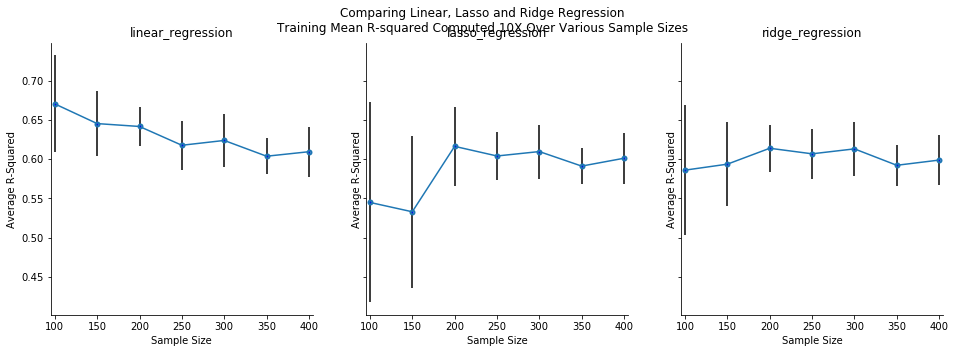

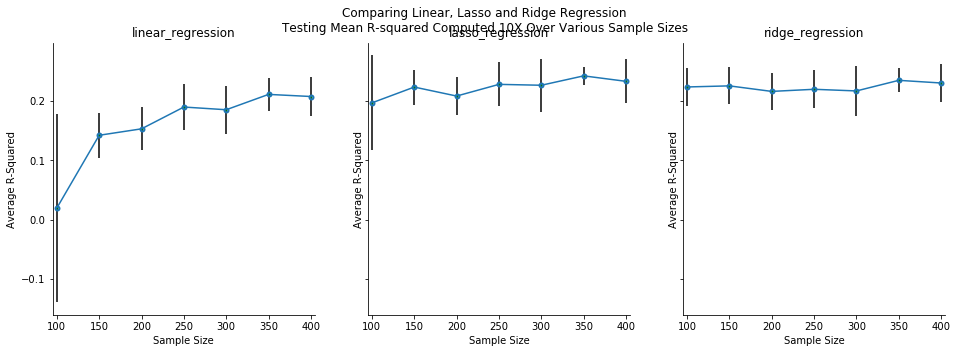

In [8]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
plt.rc('axes.spines', top=False, right=False)

# generate 10 sets of samples of size N from list of sample sizes
x_train_samples, y_train_samples = [], []

for n in range(10):
    x, y = generate_samples(x_train, y_train, sample_sizes)
    x_train_samples = x_train_samples + x
    y_train_samples = y_train_samples + y
    
# initialize lists to compile data
linear_data, ridge_data, lasso_data = [], [], []

for x, y in zip(x_train_samples, y_train_samples):
    # save sample size N
    n_samples = x.shape[0]
    
    # Linear Regression
    lm = LinearRegression().fit(x, y)
    r2_train_lm = lm.score(x, y)
    yhat_lm = lm.predict(x_test)
    r2_test_lm = r2_score(y_test, yhat_lm)
    lm_dat = {'sample_size':n_samples, 'r2_train':r2_train_lm, 'r2_test':r2_test_lm}
    linear_data.append(lm_dat)
    
    # Ridge Regression
    lm_r = RidgeCV(alphas=lambdas).fit(x, y)
    yhat_train_r = lm_r.predict(x)
    yhat_test_r = lm_r.predict(x_test)
    r2_train_r = r2_score(y, yhat_train_r)
    r2_test_r = r2_score(y_test, yhat_test_r)
    r_dat = {'sample_size':n_samples, 'r2_train':r2_train_r, 'r2_test':r2_test_r}
    ridge_data.append(r_dat)

    # Lasso Regression
    lm_l = LassoCV(alphas=lambdas).fit(x, y)
    yhat_train_l = lm_l.predict(x)
    yhat_test_l = lm_l.predict(x_test)
    r2_train_l = r2_score(y, yhat_train_l)
    r2_test_l = r2_score(y_test, yhat_test_l)
    l_dat = {'sample_size':n_samples, 'r2_train':r2_train_l, 'r2_test':r2_test_l}
    lasso_data.append(l_dat)
    
def summarize_samples(sample_performance_data):
    '''
    Inputs
    --------------------------------------
    sample_performance_data: dict of sample_size, r2_train, and r2_test
      for whichever model it is associated with
    
    Outputs
    --------------------------------------
    samples_summary: pd.DataFrame object of overall mean and std of r2 values
    samples: cleaned up pd.DataFrame object of observed r2 values for model
    '''
    samples = pd.DataFrame(sample_performance_data)
    samples = samples.set_index('sample_size', drop=True)
    samples_summary = samples.describe().ix[['mean', 'std']]
    
    return samples_summary, samples
    

lm_samples_summary, lm_samples = summarize_samples(linear_data) #lm_samples.describe().ix[['mean', 'std']]
print('OLS Summary of Results Over Various Sample Sizes:\n', lm_samples_summary, '\n')
    
ridge_samples_summary, ridge_samples = summarize_samples(ridge_data)
print('Ridge Summary of Results Over Various Sample Sizes:\n', ridge_samples_summary, '\n')

lasso_samples_summary, lasso_samples = summarize_samples(lasso_data)
print('Lasso Summary of Results Over Various Sample Sizes:\n', lasso_samples_summary)

# add model identifiers for stacking 
lm_samples['model'] = 'linear_regression'
ridge_samples['model'] = 'ridge_regression'
lasso_samples['model'] = 'lasso_regression'

def combine_models_samples(model_dfs, training=True):
    '''
    Inputs
    --------------------------------------
    model_dfs: list of sample data from trials, each marked with a column
      specifying the model with which it was trained
    training: if True, will get r2_train not r2_test
    
    Outputs
    --------------------------------------
    samples_all_summary: pd.Panel object of summary statistics
    '''
    if training: 
        r2_col = 'r2_train'
    else:
        r2_col = 'r2_test'
    
    # combine data into one pd.DataFrame object
    samples_all = pd.concat(model_dfs)
    samples_all.reset_index(drop=False, inplace=True)

    # obtain std and mean as a fn of sample size and model as groups
    samples_all_summary = samples_all.groupby(['model', 'sample_size'])[r2_col].agg({'mean':np.mean, 'std':np.std})

    # get upper and lower errors; cap them at 0 or 1
    samples_all_summary['upper_err'] = samples_all_summary['mean'] + samples_all_summary['std']
    samples_all_summary.loc[samples_all_summary.upper_err > 1.0, 'upper_err'] = 1

    samples_all_summary['lower_err'] = samples_all_summary['mean'] - samples_all_summary['std']
    samples_all_summary.loc[samples_all_summary.lower_err < 0.0, 'lower_err'] = 0

    # convert to pd.Panel for iteration and plot accessibility
    samples_all_summary = samples_all_summary.to_panel()
    samples_all_summary = samples_all_summary.swapaxes(0, 1)
    samples_all_summary = samples_all_summary.swapaxes(1, 2)
    
    return samples_all_summary

# put models into one pd.Panel object for accessibility, both train and test
model_dfs = [lm_samples, ridge_samples, lasso_samples]
samples_all_summary = combine_models_samples(model_dfs, training=True)
samples_all_summary_test = combine_models_samples(model_dfs, training=False)
    
# id models for indexing pd.Panel object
models = ['linear_regression', 'lasso_regression', 'ridge_regression']

# plot training R-squared using plt.errorbar
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), sharey=True)
for i, model in enumerate(models):
    axes[i].errorbar(samples_all_summary[model].index.values, samples_all_summary[model]['mean'],\
                    yerr=[samples_all_summary[model]['std'], samples_all_summary[model]['std']],\
                    ecolor='black', fillstyle='full', marker='o', ms=2, mew=4, mfc='blue')
    axes[i].set_title(str(model))
    axes[i].set_xlabel('Sample Size')
    axes[i].set_ylabel('Average R-Squared')
    axes[i].set_xlim((95, 405))
    
fig.suptitle('Comparing Linear, Lasso and Ridge Regression\nTraining Mean R-squared Computed 10X Over Various Sample Sizes')

# plot testing R-squared using plt.errorbar
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), sharey=True)
for i, model in enumerate(models):
    axes[i].errorbar(samples_all_summary_test[model].index.values, samples_all_summary_test[model]['mean'],\
                    yerr=[samples_all_summary_test[model]['std'], samples_all_summary_test[model]['std']],\
                    ecolor='black', fillstyle='full', marker='o', ms=2, mew=4, mfc='green')
    axes[i].set_title(str(model))
    axes[i].set_xlabel('Sample Size')
    axes[i].set_ylabel('Average R-Squared')
    axes[i].set_xlim((95, 405))
    
fig.suptitle('Comparing Linear, Lasso and Ridge Regression\nTesting Mean R-squared Computed 10X Over Various Sample Sizes')

### Lasso, Ridge and Linear Models $R^2$ Over Various Sample Sizes

Under all of the models the training $R^2$ appears to decrease with sample size, while the testing $R^2$ appears to hit a peak before falling. Part of this effect is random sampling, and part of it is the model new signal from unseen observations. It is interesting to note that Lasso appears to have smaller variance in its testing $R^2$ values compared to both Ridge and Linear Regression. This is likely due to the "muting" of vertain coefficients. 

Based on these plots, Lasso would be the preferred method for training a small sample. Its low variance is appealing, and it achieves the highest test $R^2$.

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [9]:
from scipy import stats
from statsmodels.tools.tools import add_constant

# define same linear function as used in part(b) 
def sm_linear_regression(X, Y, intercept=True):
    '''
    Inputs
    --------------------------------------
    X: np.array, np.ndarray, pd.Series or pd.DataFrame object of predictors
    Y: np.array or pd.Series object of labels
    intercept: default True, use False if no interecept desired
    
    Outputs
    --------------------------------------
    lin_model_results: statsmodels.linear_regression.OLS.fit object
    '''
    if intercept: X = sm.add_constant(X)
        
    lin_model = sm.OLS(Y, X)
    lin_model_results = lin_model.fit()
    
    return lin_model_results

def significant_coef_twotail_t(linear_model, alpha):
    '''
    Extracts significant coefficients of a linear model at alpha
    by performing a t-test on a statsmodels.linear_regression.OLSresults object
    
    Inputs
    --------------------------------------
    linear_model: statsmodels.OLS.fit object
    alpha: significance level to be split among both tails
    
    Outputs
    --------------------------------------
    sig_coef_df: pd.DataFrame object containing t-value, p-value, and coefficients
    '''
    # get coefficients, degrees of freedom, p-values and t-values
    coefficients = linear_model.params
    df_lm_all = len(linear_model.resid) - len(coefficients) - 1#linear_model.df_model
    t_values = linear_model.tvalues
    p_values = linear_model.pvalues
    
    # acquire critical t-value (by splitting alpha for two-tails) to filter and check significance
    split_alpha = alpha / 2
    critical_t = stats.t.isf([0 + split_alpha, 1 - split_alpha], df=df_lm_all)
    
    # organize coefficient info into pd.DataFrame class; filter out non-significant
    coef_df = pd.DataFrame({'coefficient':coefficients, 't_value':t_values, 'p_value':p_values})
    coef_df.index.name = 'coefficients'
    sig_coef_df = coef_df[(coef_df.t_value < min(critical_t)) | (coef_df.t_value > max(critical_t))]
    
    return sig_coef_df

def r2_score_sm(model, x, y):
    '''
    Inputs
    --------------------------------------
    model: statsmodels.linear_regression.OLS.fit object
    x: x to predict yhat
    y: actual y labels
    
    Outputs
    --------------------------------------
    r2: r-squared of linear model
    '''
    x = add_constant(x)
    yhat = model.predict(x)
    r2 = r2_score(y, yhat)
    
    return r2

In [10]:
print('Polynomial Terms Only:\n--------------------------------------')

# redefine x_train/x_test and y_train/y_test
x_train_polys, y_train = df_train[[col for col in df_train.columns if col != 'count']], df_train['count']
x_test_polys, y_test = df_test[[col for col in df_test.columns if col != 'count']], df_test['count']
        
features_to_fit = ['scaled_temp', 'scaled_atemp', 'scaled_humidity', 'scaled_windspeed']
degrees = [2, 3, 4]

def polynomials_1by1(degrees, features_to_fit, x_train_polys, x_test_polys):
    '''
    Gets polynomial degrees one feature and one degree
    at a time to avoid exploding the number of predictors
    and interaction terms
    
    Inputs
    --------------------------------------
    degrees: list of degrees to exponentiate features
    features_to_fit: column names of polynomial
    x_train_polys: pd.DataFrame of X, pre-polynomial
    x_test_polys: pd.DataFrame of X, pre-polynomial
    
    Outputs
    --------------------------------------
    x_train_polys: pd.DataFrame of transformed X
    x_test_polys: pd.DataFrame of transformed X
    '''
    for feature in features_to_fit:
        for d in degrees:
            # get name of new column by appending _degree
            feature_colname = str(feature) + '_' + str(d)

            # initialize features
            thispoly = PolynomialFeatures(d, include_bias=False)
            x_train_polys[feature_colname] = x_test_polys[feature_colname] = np.nan

            # get only the exponentiated new feature (not interaction)
            x_train_polys[feature_colname] = thispoly.fit_transform(x_train_polys[feature].values.reshape(-1, 1))
            x_test_polys[feature_colname] = thispoly.fit_transform(x_test_polys[feature].values.reshape(-1, 1))
            
    return x_train_polys, x_test_polys

x_train_polys, x_test_polys = polynomials_1by1(degrees, features_to_fit, x_train_polys, x_test_polys)

# run linear model using function defined above 
linear_model_polys = sm_linear_regression(x_train_polys, y_train)

# call custom function r2_score_sm to get r2 from statsmodels.linear_regression.OLS object
r2_polys_train = r2_score_sm(linear_model_polys, x_train_polys, y_train)
r2_polys_test = r2_score_sm(linear_model_polys, x_test_polys, y_test)

print('''
R-squared training = %.5f
R-squared testing = %.5f
''' %(r2_polys_train, r2_polys_test))

# derive significant coefficients at the 5% level using function defined above
sig_coef_df = significant_coef_twotail_t(linear_model_polys, alpha=.05)
print('Significant coefficients using a two-tailed t-test:\n\n', sig_coef_df)

Polynomial Terms Only:
--------------------------------------

R-squared training = 0.57613
R-squared testing = 0.24934

Significant coefficients using a two-tailed t-test:

                     coefficient       p_value   t_value
coefficients                                           
const               4335.264864  1.046732e-15  8.474141
workingday          1325.267338  1.858404e-10  6.597966
saturday            1371.192307  1.622418e-08  5.805064
sunday               906.047297  7.958737e-05  4.000238
winter             -1226.186543  1.612408e-02 -2.419645
rain/snow          -1581.978284  3.025734e-03 -2.989246
jul                -1613.336093  1.385447e-02 -2.475423
jun                -1125.611985  1.246346e-02 -2.513762
scaled_humidity     -136.915946  2.020827e-06 -4.845341
scaled_windspeed     -63.684229  1.744235e-03 -3.158772
scaled_humidity_2   -136.915946  2.020827e-06 -4.845341
scaled_humidity_3   -136.915946  2.020827e-06 -4.845341
scaled_humidity_4   -136.915946  2.020827

In [11]:
print('Pre-defined Interaction Terms Only:\n--------------------------------------')

# redefine x_train/x_test and y_train/y_test
x_train_ixn, y_train = df_train[[col for col in df_train.columns if col != 'count']], df_train['count']
x_test_ixn, y_test = df_test[[col for col in df_test.columns if col != 'count']], df_test['count']

# adding interaction terms for december/temperature and clear/workingday for training
clear_proxy = [int(a == b == 0) for a,b in zip(x_train_ixn['cloudy'], x_train_ixn['rain/snow'])]
x_train_ixn['workingday_clear'] = np.multiply(x_train_ixn['workingday'], clear_proxy)
x_train_ixn['dec_temp'] = np.multiply(x_train_ixn['dec'], x_train_ixn['scaled_temp'])

# adding interaction terms for december/temperature and clear/workingday for testing
clear_proxy = [int(a == b == 0) for a,b in zip(x_test_ixn['cloudy'], x_test_ixn['rain/snow'])]
x_test_ixn['workingday_clear'] = np.multiply(x_test_ixn['workingday'], clear_proxy)
x_test_ixn['dec_temp'] = np.multiply(x_test_ixn['dec'], x_test_ixn['scaled_temp'])

# run linear model using function defined above 
linear_model_allixn = sm_linear_regression(x_train_ixn, y_train)

# call custom function r2_score_sm to get r2 from statsmodels.linear_regression.OLS object
r2_ixns_train = r2_score_sm(linear_model_allixn, x_train_ixn, y_train)
r2_ixns_test = r2_score_sm(linear_model_allixn, x_test_ixn, y_test)

print('''
R-squared training = %.5f
R-squared testing = %.5f
''' %(r2_ixns_train, r2_ixns_test))

# derive significant coefficients at the 5% level using function defined above
sig_coef_df = significant_coef_twotail_t(linear_model_allixn, alpha=.05)
print('Significant coefficients using a two-tailed t-test:\n\n', sig_coef_df)

Pre-defined Interaction Terms Only:
--------------------------------------

R-squared training = 0.58038
R-squared testing = 0.26852

Significant coefficients using a two-tailed t-test:

                   coefficient       p_value   t_value
coefficients                                         
const             4038.758646  1.246548e-12  7.414626
workingday        1087.201818  3.495107e-04  3.616897
saturday          1329.606355  5.788090e-08  5.565405
sunday             906.422398  8.778459e-05  3.976108
rain/snow        -1339.914702  2.404045e-02 -2.267955
jul              -1434.479139  3.101080e-02 -2.167106
jun              -1031.732828  2.286137e-02 -2.287480
scaled_humidity   -573.250032  8.186394e-07 -5.036464
scaled_windspeed  -275.328829  8.390803e-04 -3.373590


### Comparing Linear Models

To recap our model fit in part (b), below are the predictors that exceeded the critical significance level:

                      coefficient  p_value       t_value
    workingday        1325.267338  1.858404e-10  6.597966
    saturday          1371.192307  1.622418e-08  5.805064
    sunday             906.047297  7.958737e-05  4.000238
    winter           -1226.186543  1.612408e-02 -2.419645
    rain/snow        -1581.978284  3.025734e-03 -2.989246
    jul              -1613.336093  1.385447e-02 -2.475423
    jun              -1125.611985  1.246346e-02 -2.513762
    scaled_humidity   -547.663783  2.020827e-06 -4.845341
    scaled_windspeed  -254.736916  1.744235e-03 -3.158772

This model is used as a benchmark to compare to the above fitted models.

#### Polynomial Terms Only vs. Part (b)'s Model

The polynomial-terms-only model was fit using the original primary predictors as well as the second, third, and fourth order terms of each of the continuous predictors.

The original model fit in part (b) had a testing $R^2$ more-or-less identical to the polynomial-only model fit two cells above, both of which were equal to $0.2493$. Consistent with this similar performance, the polynomial-terms-only model simply produces an expanded set of significant predictors compared with part (b). 

   - Polynomial-Terms-Only testing $R^2 = 0.24934$
   - Part (b) testing $R^2 = 0.2493$

Whereas the model in part (b) returned 9 significant predictors, the polynomial-terms-only model returned 15 significant predictors. Nine out of these fifteen significant predictors align perfectly with the model in part (b). The remaining 6 predictors are all derived from two variables, `scaled_humidity` and `scaled_windspeed` -- they include these variables' second, third, and fourth order terms. Interstingly, the coefficients on these higher-order terms are identical to the coefficients fit on their non-exponentiated root.

This indicates that a lot more noise was introduced into this model (by adding polynomial terms for each continuous predictor) to obtain a benefit of less than a $1/100000$ increase in our testing $R^2$

#### Interaction Terms Only vs. Part (b)'s Model

The interaction-terms-only model was fit using the original primary predictors as well as the pre-specified interaction terms `dec_temp` and `workingday_clear`, which are simply the products of their underlying terms.

The interaction-terms-only model exhibits a small increase in both the training and testing $R^2$ when compared with part (b). The testing $R^2$ for the interaction-terms-only model increased nearly two percentage points from the testing $R^2$ from part (b).

   - Interaction-Terms-Only testing $R^2 = 0.26582$
   - Part (b) testing $R^2 = 0.2493$
   
It is interesting to note that despite this improvement in $R^2$, the significant variables in this model are nearly the same as part (b). Eight of the nine significant predictors from part (b) make up the interaction-terms-only significant predictors, with the noteable exclusion of `winter`. This exclusion may be explained by the introduction of the interaction term `dec_temp`, which is very likely to have a strong collinearity with `winter`, and thus steal away some of its observed effect. It is also interesting to note that the coefficient term on `workingday` is diminished considerably (from ~1325 to ~1087) by the introduction of the interaction term `workingday_clear`. Finally, none of the interaction terms introduced were statistically significant at the 5% level.

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [12]:
print('Polynomial & Interaction Terms:\n--------------------------------------')

# redefine x_train/x_test and y_train/y_test
x_train, y_train = df_train[[col for col in df_train.columns if col != 'count']], df_train['count']
x_test, y_test = df_test[[col for col in df_test.columns if col != 'count']], df_test['count']

# save cols for train to avoid exploding no. of predictors
cols_for_ixn = x_train.columns.tolist()

print('''
Before Polynomials/Interactions (4th Order):
--------------------------------------
Training Shape: %s
Testing Shape:  %s
''' %(x_train.shape, x_test.shape))

# leverage pre-defined function to get polys 1by1
print('Creating polynomials for only:\n', features_to_fit, '\n')
x_train_poly_ixn, x_test_poly_ixn = polynomials_1by1(degrees, features_to_fit, x_train, x_test)

# create interactions separately and concatenate into main dataset
print('Creating interactions for only:\n', cols_for_ixn)
ixn_only = PolynomialFeatures(include_bias=False, interaction_only=True)
xtrainixn = pd.DataFrame(ixn_only.fit_transform(x_train[cols_for_ixn]))
xtestixn = pd.DataFrame(ixn_only.fit_transform(x_test[cols_for_ixn]))

x_train_poly_ixn = pd.concat([x_train_poly_ixn, xtrainixn], axis=1)
x_test_poly_ixn = pd.concat([x_test_poly_ixn, xtestixn], axis=1)

print('''
After Polynomials/Interactions (4th Order):
--------------------------------------
Training Shape: %s
Testing Shape:  %s
''' %(x_train_poly_ixn.shape, x_test_poly_ixn.shape))

Polynomial & Interaction Terms:
--------------------------------------

Before Polynomials/Interactions (4th Order):
--------------------------------------
Training Shape: (331, 28)
Testing Shape:  (400, 28)

Creating polynomials for only:
 ['scaled_temp', 'scaled_atemp', 'scaled_humidity', 'scaled_windspeed'] 

Creating interactions for only:
 ['holiday', 'workingday', 'monday', 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday', 'spring', 'summer', 'winter', 'cloudy', 'rain/snow', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'scaled_temp', 'scaled_atemp', 'scaled_humidity', 'scaled_windspeed']

After Polynomials/Interactions (4th Order):
--------------------------------------
Training Shape: (331, 446)
Testing Shape:  (400, 446)



                 r2_test  r2_train
pca_components                    
1               0.186977  0.326011
2               0.194222  0.372280
3               0.209306  0.425186
4               0.203024  0.443812
5               0.230302  0.518715


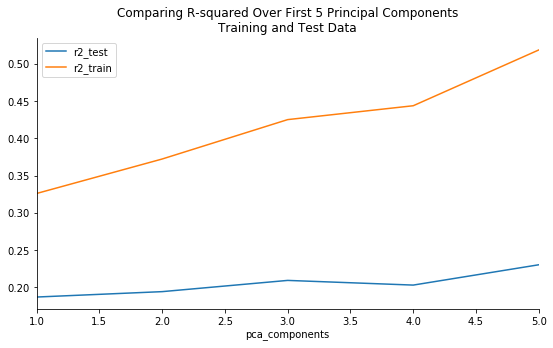

In [13]:
# PCA decomposition
from sklearn.decomposition import PCA

pca_components = np.arange(1, 6)

def generate_pca_components(pca_components, x_train, x_test):
    '''
    Compiles one training/test set of PCAs for each component in list
    
    Inputs
    --------------------------------------
    pca_components: list of integer components to fit to x_train
    x_train: original dataset of predictors to transform

    Outputs
    --------------------------------------
    x_pca: dict of new x_train_pca's at various PCA components
    x_pca_test: dict of new x_test_pcas's at various PCA components
    '''
    x_pca, x_pca_test = {}, {}
    
    for components in pca_components:
        pca = PCA(n_components=components)
        pca.fit(x_train)
        x_pca[components] = pca.transform(x_train)
        x_pca_test[components] = pca.transform(x_test)
    
    return x_pca, x_pca_test

# generate dicts of train/test PCA data
x_trains_pca, x_tests_pca = generate_pca_components(pca_components, x_train_poly_ixn, x_test_poly_ixn)

# iterate over dicts to get r2 and pca data for train/test
r2_pca = []
for components, x_pca in x_trains_pca.items():
    lm = LinearRegression()
    lm.fit(x_pca, y_train)
    r2_train = r2_score(y_train, lm.predict(x_pca))
    r2_test = r2_score(y_test, lm.predict(x_tests_pca[components]))
    r2_pca.append({'pca_components':components, \
                  'r2_train':r2_train, 'r2_test':r2_test})

# quick plot to visualize the r-squared
r2_pca_df = pd.DataFrame(r2_pca).set_index('pca_components', drop=True)
r2_pca_df.plot(figsize=(9, 5))
plt.title('Comparing R-squared Over First 5 Principal Components\nTraining and Test Data')

print(r2_pca_df)

In [14]:
# get coefficients 
pca_cols = ['pca_' + str(i) for i in np.arange(1, 6, 1)]
coefs = pd.DataFrame({'coefficient':lm.coef_, 'pca':pca_cols}).set_index('pca', drop=True)
print(coefs, '\n\n', '-'*50)

# get correlations with pca columns among 28 original cols
df_pca = pd.DataFrame(x_trains_pca[5])
df_pca.columns = pca_cols
df_pca = pd.concat([x_train_poly_ixn, df_pca], axis=1).head()
df_pca = df_pca.corr()
df_pca = df_pca[pca_cols]
df_pca = df_pca.head(28)

# print out strong correlations (absolute value) for each PCA
cutoff = 0.7
for pca in pca_cols:
    print('Strong Correlations for Principal Component: ',  pca, '\n', '-'*50, '\n')
    print(df_pca.loc[df_pca[pca].abs() >= cutoff, pca], '\n\n')

       coefficient
pca               
pca_1  -299.452671
pca_2  -153.806785
pca_3  -199.564492
pca_4  -163.834757
pca_5  -375.970702 

 --------------------------------------------------
Strong Correlations for Principal Component:  pca_1 
 -------------------------------------------------- 

workingday     -0.924523
sunday          0.924523
dec             0.849959
scaled_temp    -0.973942
scaled_atemp   -0.952404
Name: pca_1, dtype: float64 


Strong Correlations for Principal Component:  pca_2 
 -------------------------------------------------- 

thursday           -0.895404
jun                -0.895404
scaled_humidity     0.853615
scaled_windspeed   -0.968101
Name: pca_2, dtype: float64 


Strong Correlations for Principal Component:  pca_3 
 -------------------------------------------------- 

workingday      0.967691
sunday         -0.967691
scaled_temp     0.872713
scaled_atemp    0.882316
Name: pca_3, dtype: float64 


Strong Correlations for Principal Component:  pca_4 
 ----

### Dimensions of Design Matrix

The number of training features was deliberately minimized by performing a targeted approach to generating both polynomial terms and interaction terms. This approach included two specific custom methods:

   - Deriving each polynomial degree for each, pre-specified, continous variable in an iterative fashion
   - Separately creating interaction terms using the main effects (including the one-hot features) and concatenating to the dataset 
   - Original Training Shape: (331, 28); Original Testing Shape:  (400, 28)
   - Post-Transformation Training Shape: (331, 446); Post-Transformation Testing Shape:  (400, 446)
   
This approach is superior to simply calling `sklearn.preprocessing.PolynomialFeature` in a brute fashion all at once, which would have yielded tens of thousands of columns due to the explosion of features and interactions created. By following this disciplined approach, only 418 features were created from the original 28 (12 from the polynomial features, the rest from interactions between the origial main effects).

Even at this reasonably sized polynomial feature set it is still unwise to fit a regression model to all of these predictors. Firstly, even though the set of features expanded by 16X its original size, it is still very difficult to add something to the original feature set that was not originally present. This was illustrated in the afforementioned polynomial-terms-only model that achieved nearly no advantage over the original regression model in part (b), despite adding 12 "new" features. Secondly, this high-dimensional dataset will certainly include redundant information to the original set and increase the probability of overfitting. Thirdly, it is computationally inefficient to use the normal equations to minimize the sum of squared errors on high-dimensional data; this leads to long training times. Lastly, it will likely lead to inaccurate predictions.


### PCA Decomposition for Dimensionality Reduction

The data was not normalized before fitting PCA since at had already been pre-normalized from the first part of this investigation. To investigate the principal components, the training data was projected onto 1, 2, 3, 4, and 5 component vectors separately, each was fit using `LinearRegression`, and finally each was tested on the test set.

As is expected, performance on the training set improved as more principal components were added. The test performance (as measured by $R^2$) also increases as the number of components increases, except from 3 to 4 components (where it fell by a small amount). The highest test $R^2$ was observed at `PCA(n_components=5)` where $R^2 = 0.230302$. This model (using the first 5 components) appears to perform the best on the test data, however it is not a large improvement from `PCA(n_components=1)` which explained 18.7% of the variation around the mean.

### Interpretation of PCA Coefficients

PCA regression coefficients are difficult to interpret directly. To aid in this endeavor, a correlation matrix was created between all of the original predictors and the 5 PCA vectors that were generated.

- PCA 1 has a strong positive relationship with `dec` & `sun`. It also has a strong negative relationship with `scaled_temp`, `scaled_atemp`, and `workingday`. This vector seems to encompass something along the linese of "Holiday Break".
- PCA 2 encompases strong negative relationships with `thurs`, `jun` and `scaled_windspeed`, and a strong positive relationship with `scaled_humidity`.
- PCA 3 has the opposite characteristics of PCA 1. 
- PCA 4 has strong positive relationships with `wed`, `summer`, `rain/snow`, `sep` and `scaled_humidity`, while it has a strong negative relationship with `scaled_windspeed`.
- PCA 5 has a strong positive relationship with `dec`, and has strong negative relationships with `may`, `cloudy`, `scaled_temp` and `scaled_humidity`.

Further obfuscating the interpretive quality of the model is the fact that the coefficients all came out negative from the PCA model. It seems that the model picked up all of the vectors that work counteractive to the number of rentals, such as the winter holiday period and the humid days of summer. This interpretation is weaker for inference than it is for prediction.

What we can say is that the PCA model is (1) lower in dimension than the 446 column interaction/polynomial predictor set, and (2) has reduced collinearity as a result of the PCA process. While it is difficult to interpret any one of these coefficients, we can still be confident that it is a marginal improvement from running regression on a large set of potentially redundant of variables.

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [15]:
# https://medium.com/@viveksrinivasan/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-2-29e854aaab7d
def rmsle(y, y_pred):
    '''
    A function for evaluationg the ROot Squared Logarithmic Error
    (RMSLE) of the linear regression model on a data set
    
    Inputs
    --------------------------------------
    y_test: (n x 1 array of response variable vals in testing data)
    y_pred: (n x 1 array of response variable vals in testing data)

    Outputs
    --------------------------------------
    rmsle_: (float) rmsle_ = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    '''
    # Evaluate sqaured error, against target labels
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [16]:
# train model using natural log of Y as target
# rmsle on part (g) polynomial model
rmsle_g_train = rmsle(y_train, linear_model_polys.predict(add_constant(x_train_polys)))
rmsle_g_test = rmsle(y_test, linear_model_polys.predict(add_constant(x_test_polys)))

# model and r2 scores taken from part (g)
print('''
Polynomial Terms Only Model Part (g)
--------------------------------------
R-squared training = %.5f
R-squared testing = %.5f

RMSLE training = %.5f
RMSLE testing = %.5f
''' %(r2_polys_train, r2_polys_test, rmsle_g_train, rmsle_g_test))

# run linear model using function defined above 
lm_rmsle = sm_linear_regression(x_train_polys, np.log1p(y_train))

# call custom function r2_score_sm to get r2 from statsmodels.linear_regression.OLS object
r2_polys_rmsle_train = r2_score_sm(lm_rmsle, x_train_polys, np.log1p(y_train))
r2_polys_rmsle_test = r2_score_sm(lm_rmsle, x_test_polys, np.log1p(y_test))

rmsle_train = rmsle(np.log(y_train), lm_rmsle.predict(add_constant(x_train_polys)))
rmsle_test = rmsle(np.log(y_test), lm_rmsle.predict(add_constant(x_test_polys)))

print('''
Polynomial Terms Only, Trained Using RMSLE
--------------------------------------
R-squared training = %.5f
R-squared testing = %.5f

RMSLE training = %.5f
RMSLE testing = %.5f

''' %(r2_polys_rmsle_train, r2_polys_rmsle_test, rmsle_train, rmsle_test))

# derive significant coefficients at the 5% level using function defined above
sig_coef_df = significant_coef_twotail_t(lm_rmsle, alpha=.05)
print('Significant coefficients using a two-tailed t-test:\n--------------------------------------\n', sig_coef_df)


Polynomial Terms Only Model Part (g)
--------------------------------------
R-squared training = 0.57613
R-squared testing = 0.24934

RMSLE training = 0.34368
RMSLE testing = 0.51616


Polynomial Terms Only, Trained Using RMSLE
--------------------------------------
R-squared training = 0.64226
R-squared testing = 0.31765

RMSLE training = 0.03757
RMSLE testing = 0.06407


Significant coefficients using a two-tailed t-test:
--------------------------------------
                     coefficient        p_value    t_value
coefficients                                             
const                  6.874453  3.276726e-149  50.338914
holiday                1.577304   3.401368e-37  14.672436
workingday             1.835597  3.763448e-106  34.234946
saturday               1.777895   1.032865e-86  28.196837
sunday                 1.683656   1.591886e-85  27.846719
winter                -0.461525   7.331736e-04  -3.411744
rain/snow             -0.667130   3.570265e-06  -4.722340
aug      

### RMSLE as Cost Function

Above, the polynomial-terms-only model is compared with a model fit using the root mean squared logarithmic error (RMSLE, as opposed to the root mean squared error, or RMSE). The cost function is transformed by simply taking the natural log using `np.log1p` of $Y$ to train the model (a special form of the natural log which adds 1 to the vector prior to taking the log), and then using `np.log` to derive the natural logarithm when deriving the RMSLE using the `rmsle` function. It should be emphasized that `np.log1p` is *only used* during training and deriving $R^2$. When deriving the RMSLE using the `rmsle` function, we use `np.log` of the $Y$ variable since a 1 is added to $Y$ in the provided `rmsle` function. 

By using `np.log1p` to derive the natural log of the $Y$ variable we naturally transform the cost function to mirror the RMSLE function as defined below:

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

Using this approach it is shown that we improve both the RMSLE and the R-squared values, as compared with Part (g). Testing $R^2$ improved from 0.24934 to 0.31765, and the testing RMSLE improved from 0.51616 to 0.06407 by this simple change. Similarly, training $R^2$ improved from 0.57613 to 0.64226 while the training RMSLE improved from 0.34368 to 0.03757.

#### Polynomial Terms Only, Trained Using RMSE
- R-squared training = 0.57613
- R-squared testing = 0.24934
- RMSLE training = 0.34368
- RMSLE testing = 0.51616


#### Polynomial Terms Only, Trained Using RMSLE
- R-squared training = 0.64226
- R-squared testing = 0.31765
- RMSLE training = 0.03757
- RMSLE testing = 0.06407

Comparing the significant predictors between part (g) and the RMSLE-fit model, it is observed that the RMSLE-fit model adds `scaled_temp` and all of its polynomial features to the list, as well as `holiday` and `aug`. These predictors likely correspond with lower $Y$ labels in the training set, and thus the previous RMSE polynomials-only model was not sensitive enough to detect their significance.

By making the simple choice of utilizing RMSLE to penalize errors on small responses more heavily than errors on large responses we improve our model considerably.

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

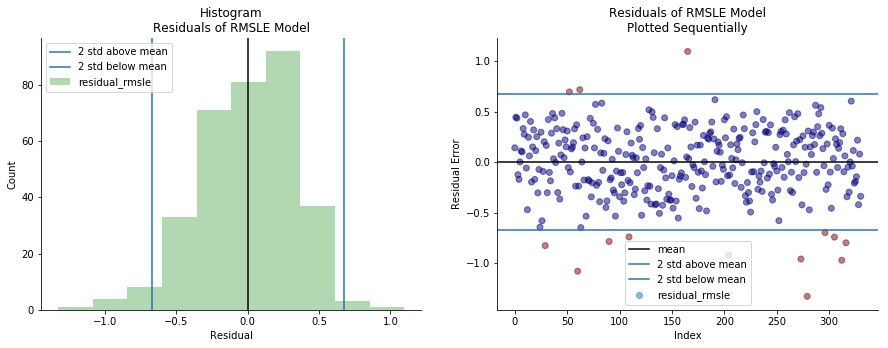

In [17]:
# get PCA vectors from above
pca_df = pd.DataFrame(x_trains_pca[5], columns=pca_cols)
pca_df['yhat_rmsle'] = lm_rmsle.predict(add_constant(x_train_polys))
pca_df['residual_rmsle'] = lm_rmsle.resid
pca_df['y_actual'] = y_test

# get mean std to mark categories top bottom 
std_residual_rmsle = pca_df['residual_rmsle'].std()
mean_residual_rmsle = pca_df['residual_rmsle'].mean()
top_5pct = mean_residual_rmsle + 2 * std_residual_rmsle
bot_5pct = mean_residual_rmsle - 2 * std_residual_rmsle
pca_df['outlier'] = (pca_df['residual_rmsle'] >= top_5pct) | (pca_df['residual_rmsle'] <= bot_5pct)

# create exploratory plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(pca_df['residual_rmsle'], alpha=0.3, color='green')
ax[0].axvline(0, c='black')
ax[0].axvline(mean_residual_rmsle + 2 * std_residual_rmsle, label='2 std above mean')
ax[0].axvline(mean_residual_rmsle - 2 * std_residual_rmsle, label='2 std below mean')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Residual')
ax[0].set_title('Histogram\nResiduals of RMSLE Model')
ax[0].legend(loc='best')

ax[1].scatter(pca_df.index.values, pca_df['residual_rmsle'], alpha=0.5, c=pca_df['outlier'], \
              cmap=plt.cm.get_cmap('jet'))
ax[1].axhline(mean_residual_rmsle, c='black', label='mean')
ax[1].axhline(mean_residual_rmsle + 2 * std_residual_rmsle, label='2 std above mean')
ax[1].axhline(mean_residual_rmsle - 2 * std_residual_rmsle, label='2 std below mean')
ax[1].set_ylabel('Residual Error')
ax[1].set_xlabel('Index')
ax[1].set_title('Residuals of RMSLE Model\nPlotted Sequentially')
ax[1].legend(loc='left')

In [18]:
# redefine train/test
x_train, y_train = df_train[[col for col in df_train.columns if col != 'count']], df_train['count']
x_test, y_test = df_test[[col for col in df_test.columns if col != 'count']], df_test['count']

# ID outlier Y train and PCA corresponding
NON_OUTLIER = (y_train <= top_5pct) | (y_train >= bot_5pct)
OUTLIER = (y_train >= top_5pct) | (y_train <= bot_5pct)
y_train_nonoutlier = y_train[NON_OUTLIER].values
x_train_nonoutlier = x_train[NON_OUTLIER].values

# train on whole set
lm_nonoutlier = sm_linear_regression(x_train_nonoutlier, y_train_nonoutlier)

# set Y values that are extreme using linear model; "set" values that were iffy
x_train_outlier = x_train.loc[OUTLIER].values
y_train.loc[OUTLIER] = lm_nonoutlier.predict(add_constant(x_train_outlier))

# re-run RMSLE model using the updated information
lm_rmsle_no = sm_linear_regression(x_train_polys, y_train)

# call custom function r2_score_sm to get r2 from statsmodels.linear_regression.OLS object
r2_polys_rmsle_train = r2_score_sm(lm_rmsle_no, x_train_polys, y_train)
r2_polys_rmsle_test = r2_score_sm(lm_rmsle_no, x_test_polys, y_test)

rmsle_train = rmsle(y_train, lm_rmsle_no.predict(add_constant(x_train_polys)))
rmsle_test = rmsle(y_test, lm_rmsle_no.predict(add_constant(x_test_polys)))

print('''
Polynomial Terms Only, 
Adjusted for Outliers
--------------------------------------
R-squared training = %.5f
R-squared testing = %.5f

RMSLE training = %.5f
RMSLE testing = %.5f

''' %(r2_polys_rmsle_train, r2_polys_rmsle_test, rmsle_train, rmsle_test))


Polynomial Terms Only, 
Adjusted for Outliers
--------------------------------------
R-squared training = 1.00000
R-squared testing = 0.24934

RMSLE training = 0.00000
RMSLE testing = 0.51616




### Identifying Erroneous Labels in the Training Data

It is known that ~5% of the training set labels are erroneous, however it is not known how these labels are distributed. Given that these errors are described as *arbitrary* we can work on the assumption that these measurement errors are not biased. The following methods were employed to detect these errors:

- Analyze at histogram of the errors in the model.
- Analyze plot of the errors as they occur over the index.

Using this to visualize, we can identify the 5% outliers by highlighting those that are two standard deviations above or below the average residuals. The mean and the standard deviation of the residuals (as fit on the RMSLE model) were identified and used as a threshold to identify values in the original `y_train` dataset that are more than two standard devations above or below the mean. Marking these indices in both the training $Y$ and $X$ data, the two groups were split apart. The `NON_OUTLIER` group was used to fit a new model using just the only the `x_train` and `y_train` records that matched the indices of `NON_OUTLIER`. This model is then utilized to predict the `y_train` that were identified as `OUTLIER`s, thus replacing these potentially erroneous $Y$ labels with models that are more in-line with what we expect.

---
--_

# APCOMP209a - Homework Question



##  Question 1: Student's t MLE

Use Maximum Likelihood Estimation to generate a linear regression model on the data provided in ``beerdata.csv`` considering two statistical models for noise: a) iid Normal and b) iid Student's t-distribution with $\nu=5$ and scale factor σ=0.5.  

Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal? 





HINTS:
1. Use the probability density function for the Student's t distribution  with location μ and scale factor σ.
2. If the MLE regressions coefficients can not be derived analytically consider numerical methods.
3. You can use sklearn or statsmodel for the Normal case 




## Question 2 (continued from HW2) 

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [19]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

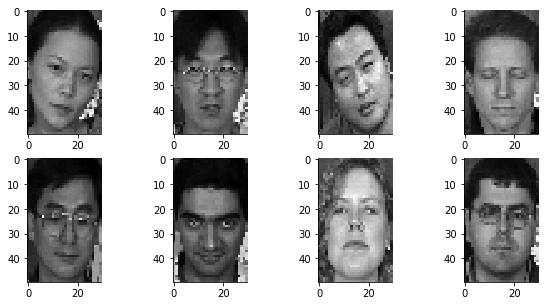

In [21]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()